In [248]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from scipy.interpolate import CubicSpline

In [249]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [250]:
from probability.visualizations import plot_pdf, plot_pdf_transform
from probability.distributions import HistogramDistribution
from helpers import interval_overlap

In [251]:
def add_mass_to_pdf_in_interval(domain, pdf, low, high, mass):
    # assert(high > low)

    # convert to index space
    # domain_step = (domain[-1] - domain[0]) / (len(domain) - 1)
    domain_step = domain[1] - domain[0]
    low_idx = (low - domain[0]) / domain_step
    high_idx = (high - domain[0]) / domain_step

    width = high_idx - low_idx
    
    if width == 0:
        pdf[int(low_idx)] += mass
        return
    
    for x in range(int(np.floor(low_idx)), int(np.ceil(high_idx))):
        overlap = interval_overlap((x, x+1), (low_idx, high_idx))
        pdf[x] += mass * overlap / width


def transform_pdf(domain, before_pdf, transform_values):
    assert(domain.shape[0] == transform_values.shape[0] == before_pdf.shape[0]+1)

    after_pdf = np.zeros_like(before_pdf)

    for i in range(len(domain) - 1):
        mass = before_pdf[i]    # mass in [i, i+1]
        image = (transform_values[i], transform_values[i+1])

        add_mass_to_pdf_in_interval(domain, after_pdf, image[0], image[1], mass)

    return after_pdf

In [252]:
domain = np.linspace(0, 10, 11, endpoint=True)
print(domain)
pdf = np.zeros_like(domain[:-1])
add_mass_to_pdf_in_interval(domain, pdf, 2, 5.5, 7)
# add_mass_to_pdf_in_interval(domain, pdf, 2, 10, 8)
print(pdf)
print(sum(pdf))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0. 0. 2. 2. 2. 1. 0. 0. 0. 0.]
7.0


In [253]:

# transform_values = 9.9 * np.sin(0.30*state_space)

# transform_values = (0.5 * state_space) ** 3


# transform_values = CubicSpline(
#     [-10, -5, 0, 5, 10],
#     [-10, *np.random.uniform(0.5*state_space[0], 0.5*state_space[-1], 3), 10]
# )(state_space)



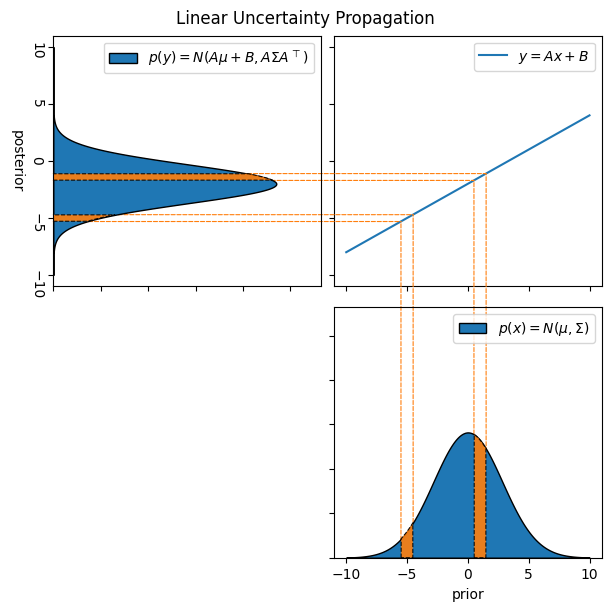

In [254]:
# Linear Belief Propogation Example

# define the domain
state_space = np.linspace(-10, 10, 1000, endpoint=True)

# define the prior
dx = state_space[1] - state_space[0]
prior = multivariate_normal.pdf(state_space[:-1] + dx/2, 0, 8)     # bins evaluated at midpoint

# define the linear transform
transform_values = 0.6 * state_space - 2.0
transform_values = np.clip(transform_values, state_space[0], state_space[-2])

# compute the posterior
posterior = transform_pdf(state_space, prior, transform_values)

# visualize
plot_pdf_transform(
    state_space, prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = N(A\mu + B, A \Sigma A^\top)$",
    transform_label=r"$y = Ax + B$"
)

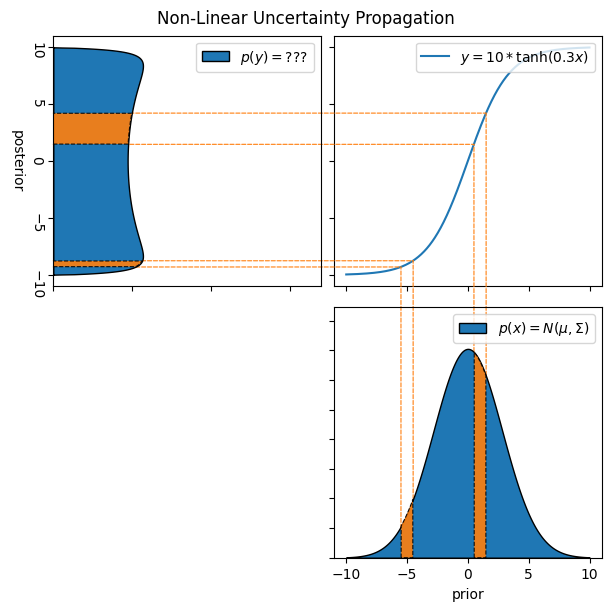

In [255]:
# Non-Linear Belief Propogation Example

# define the domain
state_space = np.linspace(-10, 10, 1000, endpoint=True)

# define the prior
dx = state_space[1] - state_space[0]
prior = multivariate_normal.pdf(state_space[:-1] + dx/2, 0, 8)     # bins evaluated at midpoint

# define the non-linear transform
transform_values = 10 * np.tanh(0.3 * state_space)
transform_values = np.clip(transform_values, state_space[0], state_space[-2])

# compute the posterior
posterior = transform_pdf(state_space, prior, transform_values)

# visualize
plot_pdf_transform(
    state_space, prior, transform_values, posterior,
    slice_highlights=[(0.5, 1.5), (-5.5, -4.5)],
    title="Non-Linear Uncertainty Propagation",
    prior_label=r"$p(x) = N(\mu, \Sigma)$",
    posterior_label=r"$p(y) = ???$",
    transform_label=r"$y = 10 * \tanh(0.3x)$",
)

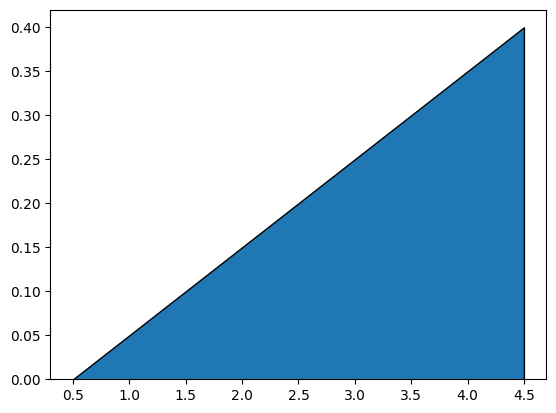

In [266]:
# from probability.distributions import HistogramDistribution

domain_bounds = [(0.0, 5.0)]
bin_counts = [5]
values = np.linspace(0, 1, 5)
values /= np.sum(values)
dist = HistogramDistribution(domain_bounds, bin_counts, values)

# dist.get_mean()
# dist.get_covariance()

dist.pdf(np.array([
    [-0.5],
    [0.0],
    [0.5],
    [1.0],
    [1.5],
    [2.0],
    [2.5]
]))

# TODO: write one top-level function for plotting a RandomVariable
plot_pdf(plt.gca(), dist.domain.flat, dist.values)

ValueError: 'x' is not 1-dimensional

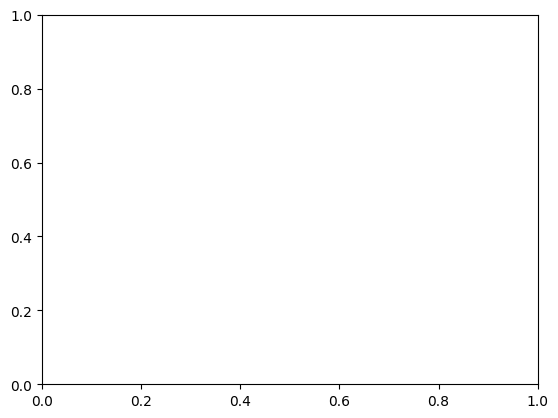

In [259]:
domain_bounds = [(-2.0, +2.0), (-5.0, 5.0)]
bin_counts = [4, 10]      # yields square bins
values = np.ones((4, 10))
values /= np.sum(values)
dist = HistogramDistribution(domain_bounds, bin_counts, values)

# dist.get_covariance()
dist.pdf(np.array([
    [0, 0],
    [0, 1],
    [0, 2]
]))

(1000, 1)
(1000, 1)


(0.0, 1.0)

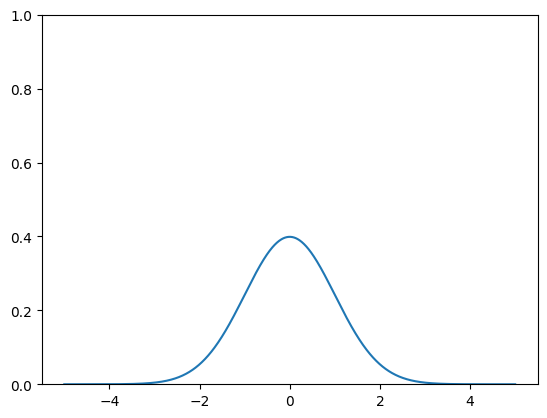

In [258]:
from probability.distributions import GaussianDistribution

dist = GaussianDistribution(np.array([[0.0]]), np.array([[1.0]]))

domain = np.linspace(-5, 5, 1000).reshape(-1, 1)
dist.pdf(domain).shape
plt.plot(domain, dist.pdf(domain))
plt.ylim(0, 1.0)